<a href="https://colab.research.google.com/github/SergioMoraa/ProyectoFinalTAM/blob/main/proyecto_final_pdi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

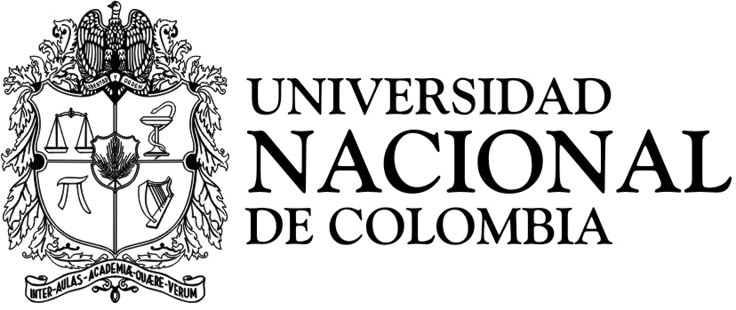
#Presentacion del Codigo Proyecto Final TAM
#Universidad Nacional de Colombia Sede Manizales
###Facultada Ingeníeria y Arquitectura - Ingeníeria Electrónica
Estudiante: Sergio Andrés Mora Orrego - Mateo Duque Gaviria - Juan esteban Villada Sierra

In [ ]:
%%capture
!pip install ultralytics roboflow

## Instalación de dependencias

En esta celda instalamos los paquetes necesarios para el proyecto:
- `ultralytics`: Para usar modelos YOLO (You Only Look Once) para detección de objetos
- `roboflow`: Para descargar y gestionar datasets de visión por computadora

El comando `%%capture` evita que se muestre el output detallado de la instalación.

In [ ]:
!python -V
!pip list | grep torch
!pip list | grep ultralytics

Python 3.11.13
pytorch-ignite                        0.5.2
pytorch-lightning                     2.5.2
torch                                 2.6.0+cu124
torchao                               0.10.0
torchaudio                            2.6.0+cu124
torchdata                             0.11.0
torchinfo                             1.8.0
torchmetrics                          1.7.3
torchsummary                          1.5.1
torchtune                             0.6.1
torchvision                           0.21.0+cu124
ultralytics                           8.3.169
ultralytics-thop                      2.0.14


## Verificación de versiones

Verificamos:
1. La versión de Python con `python -V`
2. Las versiones instaladas de PyTorch y sus paquetes relacionados
3. La versión de ultralytics

Esto es importante para garantizar compatibilidad entre paquetes.

In [ ]:
# -*- coding: utf-8 -*-
# Importación de bibliotecas necesarias
import os
import yaml
import gdown
import wandb
import shutil
import requests
import ipywidgets as widgets
import cv2
import numpy as np
from pathlib import Path
from ultralytics import YOLO
from roboflow import Roboflow
from IPython.display import display, Image, clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torchvision
import torch.nn as nn
from torchvision.io import ImageReadMode
import torchvision.transforms.functional as TF

# Deshabilitar Weights & Biases para evitar registros innecesarios
os.environ['WANDB_DISABLED'] = 'true'

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Importación de bibliotecas

Importamos todas las bibliotecas necesarias para el proyecto:

1. **Manipulación de datos y sistema**:
   - `os`, `shutil`, `pathlib`: Para manejo de archivos y directorios
   - `yaml`: Para trabajar con archivos de configuración YAML

2. **Visualización**:
   - `matplotlib`, `IPython.display`: Para mostrar imágenes y gráficos
   - `ipywidgets`: Para crear elementos interactivos

3. **Deep Learning y Visión por Computadora**:
   - `torch`, `torchvision`: PyTorch y sus herramientas para visión
   - `ultralytics`: Implementación de YOLO
   - `cv2` (OpenCV): Procesamiento de imágenes

4. **Gestión de datasets**:
   - `roboflow`: Para descargar datasets
   - `gdown`: Para descargar archivos de Google Drive

5. **Configuración adicional**:
   - Deshabilitamos Weights & Biases (`wandb`) para evitar logs no deseados

In [ ]:

rf = Roboflow(api_key="CgQKRcjD3uXFQfu0qt1e")
project = rf.workspace("pdi-sp8rw").project("face-id-zw8mi")
version = project.version(2)
dataset = version.download("yolov5")
print(f"Dataset de Roboflow descargado en: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Face-ID-2 in yolov5pytorch:: 100%|██████████| 4502/4502 [00:00<00:00, 7022.31it/s]

Dataset de Roboflow descargado en: /kaggle/working/Face-ID-2


## Descarga del Dataset

1. **Autenticación con Roboflow**:
   - Usamos una API key para acceder al servicio de Roboflow
   
2. **Acceso al proyecto específico**:
   - Accedemos al workspace "pdi-sp8rw" y proyecto "face-id-zw8mi"
   - Seleccionamos la versión 1 del dataset

3. **Descarga del dataset**:
   - Descargamos el dataset en formato YOLOv5
   - Mostramos la ubicación donde se guardó el dataset

Este dataset contiene imágenes etiquetadas para entrenar nuestro modelo de reconocimiento facial.

In [ ]:
data_config = {
    'path': '/kaggle/working/Face-ID-2',  # Ruta DIRECTA al folder del dataset
    'train': 'train/images',  # Sin prefijos adicionales
    'val': 'valid/images',    # Sin prefijos adicionales
    'test': 'test/images',    # Sin prefijos adicionales
    'names': {0: 'Acceso denegado', 1: 'Acceso permitido'},
    'nc': 2  # Número de clases (CRÍTICO)
}

yaml_path = '/kaggle/working/Face-ID-2/data_config.yaml'  # Guarda dentro del dataset
with open(yaml_path, 'w') as yaml_file:
    yaml.dump(data_config, yaml_file, default_flow_style=False)

## Configuración del Dataset

Creamos un archivo YAML de configuración que contiene:

1. **Estructura del dataset**:
   - Rutas a los directorios de entrenamiento, validación y prueba
   - La ruta base donde se encuentra el dataset

2. **Configuración de clases**:
   - `names`: Mapeo de clases (0: "Acceso denegado", 1: "Acceso permitido")
   - `nc`: Número de clases (2 en este caso)

Este archivo es esencial para que YOLO entienda la estructura de nuestro dataset.

In [ ]:
# Verifica que las rutas son correctas
import os
print("¿Existe train?", os.path.exists('/kaggle/working/Face-ID-2/train/images'))
print("¿Existe valid?", os.path.exists('/kaggle/working/Face-ID-2/valid/images'))
print("¿Existe test?", os.path.exists('/kaggle/working/Face-ID-2/test/images'))

¿Existe train? True
¿Existe valid? True
¿Existe test? True


## Verificación de rutas

Antes de entrenar, verificamos que:
1. El directorio de entrenamiento existe
2. El directorio de validación existe
3. El directorio de prueba existe

Esta validación previene errores durante el entrenamiento por rutas incorrectas.

In [ ]:
model = YOLO('yolov10s.pt')
results = model.train(
    data='/kaggle/working/Face-ID-2/data_config.yaml',  # Ruta ABSOLUTA al YAML
    epochs=90,
    imgsz=640,
    device=[0, 1]
)

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/Face-ID-2/data_config.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=90, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, 

train: Scanning /kaggle/working/Face-ID-2/train/labels.cache... 1968 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1968/1968 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 690.2±456.0 MB/s, size: 50.9 KB)


val: Scanning /kaggle/working/Face-ID-2/valid/labels.cache... 185 images, 0 backgrounds, 0 corrupt: 100%|██████████| 185/185 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0005), 111 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 90 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/90      2.56G      2.829      8.124      3.047         22        640: 100%|██████████| 123/123 [00:32<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.25it/s]


                   all        185        287      0.155      0.421      0.226      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/90      2.99G       3.11      3.575      3.142         14        640: 100%|██████████| 123/123 [00:29<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.74it/s]


                   all        185        287     0.0556       0.14    0.00872    0.00312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/90      3.03G      3.139      3.419      3.124         18        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.87it/s]


                   all        185        287      0.105      0.161     0.0693     0.0256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/90      3.08G      3.075      3.268      3.072         13        640: 100%|██████████| 123/123 [00:28<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.70it/s]


                   all        185        287       0.37      0.397      0.376      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/90      3.12G      3.015      3.177      3.016         22        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.53it/s]


                   all        185        287       0.71      0.573      0.642       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/90      3.12G      2.844      2.846      2.891         22        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.67it/s]


                   all        185        287      0.786      0.635      0.757      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/90      3.17G      2.779      2.693      2.841         25        640: 100%|██████████| 123/123 [00:28<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.66it/s]


                   all        185        287      0.808      0.631      0.744      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/90      3.17G      2.785      2.594      2.825         21        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]


                   all        185        287      0.801      0.685       0.78      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/90      3.17G      2.679      2.446      2.774         19        640: 100%|██████████| 123/123 [00:28<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.63it/s]


                   all        185        287      0.756       0.73      0.796      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/90      3.17G      2.598      2.407      2.737         25        640: 100%|██████████| 123/123 [00:29<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


                   all        185        287      0.834      0.756      0.837      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/90      3.17G      2.638      2.379      2.759         50        640: 100%|██████████| 123/123 [00:28<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.76it/s]


                   all        185        287      0.878      0.724      0.843      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/90      3.17G      2.538      2.177      2.654         13        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.55it/s]


                   all        185        287       0.82      0.706      0.804      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/90      3.17G      2.537      2.172      2.682         27        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.69it/s]


                   all        185        287       0.87      0.716      0.811      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/90      3.17G      2.505      2.097      2.659         18        640: 100%|██████████| 123/123 [00:29<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.83it/s]


                   all        185        287      0.847      0.749      0.818      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/90      3.17G      2.455       1.99      2.607         19        640: 100%|██████████| 123/123 [00:29<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.69it/s]


                   all        185        287      0.798      0.702      0.798      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/90      3.17G      2.467      1.957      2.611         21        640: 100%|██████████| 123/123 [00:28<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.70it/s]


                   all        185        287      0.859      0.752      0.838      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/90      3.17G      2.408      2.029      2.584         20        640: 100%|██████████| 123/123 [00:28<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.69it/s]


                   all        185        287      0.864      0.713      0.811      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/90      3.17G      2.435       1.94      2.585         20        640: 100%|██████████| 123/123 [00:28<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]


                   all        185        287      0.885      0.782      0.871      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/90      3.17G      2.369      1.852      2.566         21        640: 100%|██████████| 123/123 [00:29<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.76it/s]


                   all        185        287      0.847      0.781      0.858      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/90      3.17G      2.268      1.741      2.525         22        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]


                   all        185        287      0.886      0.789      0.885      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/90      3.17G      2.378      1.793      2.554         22        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.74it/s]


                   all        185        287      0.826      0.826      0.861      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/90      3.17G       2.29       1.75      2.525         10        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


                   all        185        287      0.894      0.774      0.859      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/90      3.17G      2.294      1.802      2.522         18        640: 100%|██████████| 123/123 [00:28<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.60it/s]


                   all        185        287      0.893      0.813      0.885      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/90      3.17G       2.26      1.682      2.485         17        640: 100%|██████████| 123/123 [00:28<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.45it/s]


                   all        185        287      0.875      0.805      0.879      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/90      3.17G      2.299      1.686      2.496         19        640: 100%|██████████| 123/123 [00:28<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.52it/s]


                   all        185        287      0.887      0.829      0.895      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/90      3.17G      2.286      1.635      2.511         28        640: 100%|██████████| 123/123 [00:28<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.73it/s]


                   all        185        287      0.851      0.805      0.875      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/90      3.17G      2.197      1.608      2.445         14        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.78it/s]


                   all        185        287      0.909      0.747      0.868      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/90      3.17G      2.334      1.716      2.506         32        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.83it/s]


                   all        185        287      0.841      0.768      0.837      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/90      3.17G      2.276      1.632      2.464         19        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.69it/s]


                   all        185        287      0.866      0.846      0.896      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/90      3.17G      2.136      1.561      2.434         25        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.68it/s]


                   all        185        287      0.916      0.795      0.887      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/90      3.17G      2.131      1.508      2.438         17        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.81it/s]


                   all        185        287      0.904      0.781      0.882       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/90      3.17G       2.13      1.457      2.402         19        640: 100%|██████████| 123/123 [00:28<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.83it/s]


                   all        185        287      0.891      0.834      0.889      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/90      3.17G      2.185        1.5       2.43         22        640: 100%|██████████| 123/123 [00:28<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.84it/s]


                   all        185        287      0.806      0.852      0.876      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/90      3.17G      2.097      1.483      2.413         20        640: 100%|██████████| 123/123 [00:29<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.54it/s]


                   all        185        287      0.905      0.804      0.877      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/90      3.17G      2.095      1.384      2.398         30        640: 100%|██████████| 123/123 [00:28<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.70it/s]


                   all        185        287      0.937      0.799      0.908      0.684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/90      3.17G      2.111      1.414      2.402         23        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.77it/s]


                   all        185        287      0.918      0.861      0.904      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/90      3.17G      2.125      1.487      2.402         28        640: 100%|██████████| 123/123 [00:28<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.73it/s]


                   all        185        287      0.901      0.841      0.903      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/90      3.17G      2.081      1.448      2.379         18        640: 100%|██████████| 123/123 [00:28<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.81it/s]


                   all        185        287      0.899      0.839      0.903      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/90      3.17G      2.029      1.353      2.372         18        640: 100%|██████████| 123/123 [00:29<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.84it/s]


                   all        185        287      0.914      0.858      0.907      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/90      3.17G      2.079       1.36      2.378         24        640: 100%|██████████| 123/123 [00:28<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.79it/s]


                   all        185        287      0.881      0.841      0.887      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/90      3.17G      2.039      1.355      2.368         19        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.81it/s]


                   all        185        287       0.88      0.843      0.905      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/90      3.17G      1.975       1.28      2.348         19        640: 100%|██████████| 123/123 [00:28<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


                   all        185        287      0.916       0.85      0.912      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/90      3.17G      1.999      1.338      2.372         14        640: 100%|██████████| 123/123 [00:28<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.77it/s]


                   all        185        287      0.922      0.823      0.897      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/90      3.17G      2.019      1.295      2.376         13        640: 100%|██████████| 123/123 [00:29<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.80it/s]


                   all        185        287      0.923      0.829      0.896      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/90      3.17G      1.973      1.281      2.318         17        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.86it/s]


                   all        185        287      0.923      0.839      0.902      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/90      3.17G      1.939      1.268      2.333         20        640: 100%|██████████| 123/123 [00:28<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


                   all        185        287      0.919      0.836      0.903      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/90      3.17G       1.93      1.283      2.303         19        640: 100%|██████████| 123/123 [00:28<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.77it/s]


                   all        185        287      0.924      0.837      0.914      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/90      3.17G      1.984      1.287      2.329         33        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]


                   all        185        287      0.932      0.837      0.903      0.682

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/90      3.17G      1.884      1.189       2.27         22        640: 100%|██████████| 123/123 [00:28<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.79it/s]


                   all        185        287      0.921      0.842      0.901      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/90      3.17G      1.982      1.259      2.335         14        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.82it/s]


                   all        185        287      0.923      0.821      0.882      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/90      3.17G      1.915      1.193      2.271         41        640: 100%|██████████| 123/123 [00:28<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.86it/s]


                   all        185        287      0.901      0.857      0.893      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/90      3.17G      1.898      1.207      2.311         38        640: 100%|██████████| 123/123 [00:28<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.86it/s]


                   all        185        287      0.921      0.834      0.899      0.684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/90      3.17G      1.897      1.209      2.297         26        640: 100%|██████████| 123/123 [00:28<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.87it/s]


                   all        185        287      0.923       0.87      0.919      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/90      3.17G      1.817      1.127      2.257         12        640: 100%|██████████| 123/123 [00:28<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.93it/s]


                   all        185        287      0.926      0.852      0.909      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/90      3.17G      1.855      1.125      2.277         25        640: 100%|██████████| 123/123 [00:28<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.81it/s]


                   all        185        287      0.922      0.841      0.909      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/90      3.17G      1.758      1.054      2.232         14        640: 100%|██████████| 123/123 [00:28<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


                   all        185        287      0.916      0.863      0.915      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/90      3.17G       1.82      1.102      2.219         21        640: 100%|██████████| 123/123 [00:28<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.79it/s]


                   all        185        287      0.887      0.879      0.915      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/90      3.17G      1.792      1.077      2.251         20        640: 100%|██████████| 123/123 [00:28<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.74it/s]


                   all        185        287      0.925      0.848      0.912      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/90      3.17G      1.865      1.136      2.263         26        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.71it/s]


                   all        185        287      0.892      0.873       0.91      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/90      3.17G      1.744      1.055      2.223         20        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


                   all        185        287      0.894      0.862      0.905      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/90      3.17G      1.729      1.027      2.214         20        640: 100%|██████████| 123/123 [00:28<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.81it/s]


                   all        185        287      0.927      0.862      0.911      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/90      3.17G      1.753      1.071      2.211         14        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.83it/s]


                   all        185        287      0.888      0.876       0.91      0.692

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/90      3.17G       1.75      1.025      2.214         23        640: 100%|██████████| 123/123 [00:28<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.86it/s]


                   all        185        287      0.931      0.848      0.909      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/90      3.17G      1.655      1.005      2.167         15        640: 100%|██████████| 123/123 [00:28<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.81it/s]


                   all        185        287      0.914      0.855      0.899      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/90      3.17G      1.669     0.9858      2.158         25        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.82it/s]


                   all        185        287      0.888      0.883      0.911      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/90      3.17G      1.671     0.9813       2.16         11        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.91it/s]


                   all        185        287      0.942       0.87      0.925      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/90      3.17G      1.738     0.9914      2.215         19        640: 100%|██████████| 123/123 [00:29<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.88it/s]


                   all        185        287       0.91      0.891      0.917        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/90      3.17G      1.694      1.008      2.194         29        640: 100%|██████████| 123/123 [00:28<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.79it/s]


                   all        185        287      0.944      0.873       0.92      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/90      3.17G      1.677     0.9802      2.159         27        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.94it/s]


                   all        185        287      0.929      0.847      0.913      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/90      3.17G      1.706      1.023      2.173         28        640: 100%|██████████| 123/123 [00:28<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.88it/s]


                   all        185        287      0.905      0.866      0.905      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/90      3.17G      1.706     0.9619      2.171         23        640: 100%|██████████| 123/123 [00:28<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.86it/s]


                   all        185        287      0.936      0.862      0.918      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/90      3.17G      1.615     0.9352      2.156         37        640: 100%|██████████| 123/123 [00:28<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.84it/s]


                   all        185        287      0.952      0.842      0.913      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/90      3.17G      1.595     0.8764      2.137         37        640: 100%|██████████| 123/123 [00:28<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.79it/s]


                   all        185        287       0.94      0.866      0.917      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/90      3.17G      1.559     0.9192      2.143         18        640: 100%|██████████| 123/123 [00:28<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.65it/s]


                   all        185        287      0.899      0.878      0.911      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/90      3.17G      1.563     0.8996       2.14         24        640: 100%|██████████| 123/123 [00:28<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.58it/s]


                   all        185        287      0.948      0.842      0.921      0.701


  0%|          | 0/123 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/90      3.17G      1.622     0.9061       2.17         19        640: 100%|██████████| 123/123 [00:28<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.78it/s]


                   all        185        287      0.917      0.881      0.921      0.699


  0%|          | 0/123 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/90      3.17G      1.529     0.8412      2.106         30        640: 100%|██████████| 123/123 [00:28<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.81it/s]


                   all        185        287      0.927      0.864      0.917      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/90      3.17G      1.566     0.8801      2.113         32        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.83it/s]


                   all        185        287      0.932      0.866      0.918      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/90      3.17G      1.608      0.891      2.138         22        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


                   all        185        287      0.911      0.881      0.918      0.692

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/90      3.17G      1.584     0.9498      2.131         20        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.84it/s]


                   all        185        287      0.942      0.852       0.92      0.698
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      81/90      3.17G      1.389     0.6647       2.04          8        640: 100%|██████████| 123/123 [00:29<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.74it/s]


                   all        185        287      0.937      0.855      0.924      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      82/90      3.17G      1.347     0.6247      1.998          8        640: 100%|██████████| 123/123 [00:28<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.90it/s]


                   all        185        287      0.931      0.865      0.919        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      83/90      3.17G      1.266       0.56      1.993          8        640: 100%|██████████| 123/123 [00:28<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.99it/s]


                   all        185        287      0.943      0.853      0.919      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      84/90      3.17G      1.321     0.6142      2.005          9        640: 100%|██████████| 123/123 [00:28<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.85it/s]


                   all        185        287      0.925       0.88      0.926      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      85/90      3.17G      1.259     0.5738      1.984         11        640: 100%|██████████| 123/123 [00:28<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]


                   all        185        287      0.934      0.881      0.928      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      86/90      3.17G      1.319     0.6016      1.997          8        640: 100%|██████████| 123/123 [00:28<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.83it/s]


                   all        185        287      0.952      0.862       0.92      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      87/90      3.17G      1.223     0.5505      1.967          8        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.94it/s]


                   all        185        287      0.928      0.865      0.922      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      88/90      3.17G      1.222     0.5527      1.961         10        640: 100%|██████████| 123/123 [00:28<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]


                   all        185        287       0.93       0.87      0.918      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      89/90      3.17G      1.178     0.5346      1.928         11        640: 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.78it/s]


                   all        185        287      0.945      0.868      0.925      0.711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      90/90      3.17G       1.26     0.5706      1.974         12        640: 100%|██████████| 123/123 [00:28<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.81it/s]


                   all        185        287      0.929      0.869      0.917       0.71

90 epochs completed in 0.778 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 16.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 16.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,218,774 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.75it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        185        287      0.925      0.881      0.926      0.712
       Acceso denegado         95        193      0.882      0.777      0.859      0.518
      Acceso permitido         94         94      0.969      0.986      0.994      0.907
Speed: 0.2ms preprocess, 5.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train2


## Entrenamiento del Modelo

1. **Carga del modelo base**:
   - Usamos YOLOv10s (versión pequeña) preentrenado ('yolov10s.pt')

2. **Configuración del entrenamiento**:
   - `data`: Ruta al archivo YAML de configuración
   - `epochs`: 90 épocas de entrenamiento
   - `imgsz`: Tamaño de imagen de entrada (640x640 píxeles)
   - `device`: Usamos GPUs 0 y 1 para entrenamiento acelerado

Durante el entrenamiento, se mostrarán métricas como:
- Pérdida (box_loss, cls_loss)
- Precisión (mAP50)
- Uso de memoria GPU

In [ ]:
import os
print(os.listdir('/kaggle/working/runs/detect/train/weights/'))

['best.pt', 'last.pt']


## Verificación de resultados del entrenamiento

Listamos los archivos en el directorio de pesos del entrenamiento:
- `best.pt`: Mejor modelo según métricas de validación
- `last.pt`: Último modelo entrenado

Estos archivos contienen los pesos del modelo que podemos usar para inferencia.

In [ ]:
# Cargar el modelo entrenado desde la ubicación correcta
model_path = '/kaggle/working/runs/detect/train/weights/best.pt'  # Usar best.pt que es el mejor modelo
model = YOLO(model_path)

# Realizar validación del modelo
validation_results = model.val(
    data=yaml_path,  # Ruta al archivo YAML
    imgsz=640,       # Tamaño de las imágenes
    batch=16,        # Tamaño del lote
    conf=0.5,        # Umbral de confianza
    iou=0.6,         # Umbral de IoU
    device='0'       # Dispositivo GPU
)

# Visualizar métricas de validación (ajustar rutas)
confusion_matrix_path = "/kaggle/working/runs/detect/train/confusion_matrix.png"
f1_curve_path = "/kaggle/working/runs/detect/train/BoxF1_curve.png"

# Verificar que los archivos existen antes de intentar cargarlos
import os
if os.path.exists(confusion_matrix_path) and os.path.exists(f1_curve_path):
    confusion_matrix = mpimg.imread(confusion_matrix_path)
    f1_curve = mpimg.imread(f1_curve_path)

    # Mostrar imágenes de métricas
    fig, axis = plt.subplots(1, 2, figsize=(18, 8))
    axis[0].imshow(confusion_matrix)
    axis[0].set_title('Matriz de Confusión')
    axis[0].axis('off')
    axis[1].imshow(f1_curve)
    axis[1].set_title('Curva F1')
    axis[1].axis('off')
    plt.show()
else:
    print("No se encontraron los archivos de métricas en las rutas especificadas.")
    print("Buscar en:", os.listdir('/kaggle/working/runs/detect/train/'))

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,218,774 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1162.4±302.4 MB/s, size: 39.9 KB)


val: Scanning /kaggle/working/Face-ID-2/valid/labels.cache... 185 images, 0 backgrounds, 0 corrupt: 100%|██████████| 185/185 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]
invalid value encountered in less
invalid value encountered in less


                   all        185        287      0.944      0.813      0.893      0.723
       Acceso denegado         95        193      0.899      0.648      0.797      0.546
      Acceso permitido         94         94      0.989      0.979      0.989        0.9
Speed: 0.3ms preprocess, 11.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val
No se encontraron los archivos de métricas en las rutas especificadas.
Buscar en: ['weights', 'train_batch0.jpg', 'train_batch1.jpg', 'results.csv', 'args.yaml', 'labels_correlogram.jpg', 'labels.jpg', 'train_batch2.jpg']


### Evaluación del modelo entrenado

Parámetros de validación:
1. **batch=16**: Procesa 16 imágenes simultáneamente
2. **conf=0.5**: Filtra detecciones con <50% confianza
3. **iou=0.6**: Umbral de solapamiento para NMS

Métricas calculadas:
- Precision: % de predicciones correctas
- Recall: % de objetos detectados
- mAP: Precisión media en diferentes umbrales
- F1: Balance entre precisión y recall

- ## Evaluación del Modelo

1. **Carga del mejor modelo**:
   - Cargamos 'best.pt' que tiene los mejores pesos según las métricas

2. **Validación**:
   - Evaluamos el modelo con el conjunto de validación
   - Configuración:
     * Tamaño de imagen: 640x640
     * Batch size: 16
     * Confianza mínima: 0.5
     * IoU threshold: 0.6
     * Dispositivo: GPU 0

3. **Visualización de resultados**:
   - Mostramos la matriz de confusión
   - Mostramos la curva F1
   - Estas métricas nos ayudan a entender el rendimiento del modelo

**Interpretación de resultados**:
- Matriz de confusión: Muestra los aciertos/errores entre clases
- Curva F1: Muestra el balance entre precisión y recall


Imágenes disponibles para validación:
0: -2022-02-08-190144_jpg.rf.4329099bea1ab0bf3d216c654ab60060.jpg
1: 030823_jpg.rf.4e0a58bb49ee45ef0432aac4cdff2d26.jpg
2: 0346f330983a068db0633f96d4a13de873-06-angry_rsquare_w700_jpg.rf.82b17efc8d2a28240eb7bae29aeef8aa.jpg
3: 046187_jpg.rf.44f0e4fbf675d119aae75c04f1da469b.jpg
4: 05-12-21-happy-people_jpg.rf.09795b3c2e52df919b9d6abab88f53fe.jpg
5: 068402_jpg.rf.e51a758ef458b87729c37a2a9cb656ca.jpg
6: 072161_jpg.rf.ae18bf557c98aa83c1a32ffe90421ace.jpg
7: 106222_jpg.rf.d60e2deb3508dc569847a49575371c60.jpg
8: 115786_jpg.rf.30743894ac1dfd005c9ac80a0875040b.jpg
9: 1564075_jpg.rf.011bfd60bda3cb49bcad6412b8d0d85a.jpg
10: 20201112-Alexithymia-844_jpg.rf.b65c3db0bab5e8b1aea518a0060441d6.jpg
11: 20231205_052322_024_jpg.rf.65cb2c5a09e08a5ca5100e4b8831b8ad.jpg
12: 2560px-Happy_People_jpg.rf.0d5fc36aa87f2faa1c296ac4991d4f6c.jpg
13: 360_F_548848756_IlV9Y9HV8chb6mSuc3PBamYRT9gIn8Vo_jpg.rf.02d278f40a50153df432cb2405fc9744.jpg
14: 418088_jpg.rf.aa1557eb9459f73e29a

Selección:  33



Procesando imagen: IMG_1720_JPG.rf.b560c4fe527d8a674f1e789a84a552b7.jpg

image 1/1 /kaggle/working/Face-ID-2/test/images/IMG_1720_JPG.rf.b560c4fe527d8a674f1e789a84a552b7.jpg: 640x640 1 Acceso permitido, 15.0ms
Speed: 2.3ms preprocess, 15.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


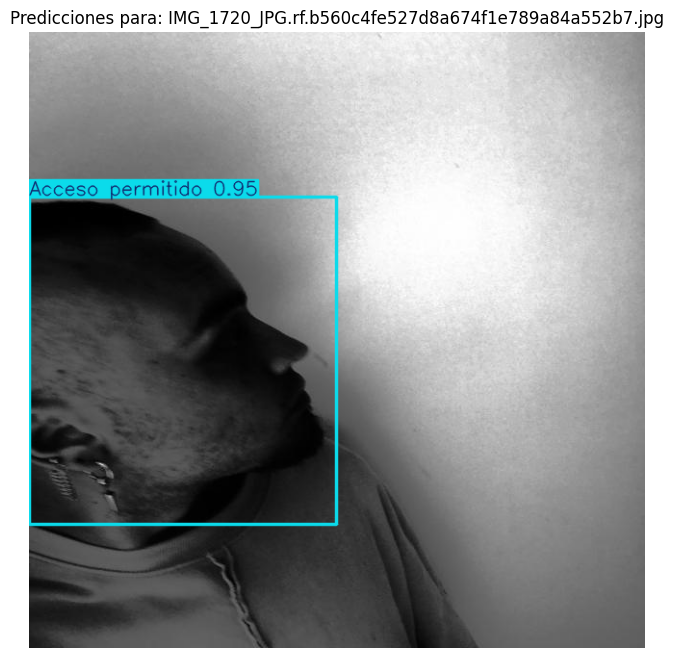

Clase: Acceso permitido | Confianza: 0.95

Ingresa el número de imagen a validar (0-91)
O ingresa 'q' para salir


Selección:  3



Procesando imagen: 046187_jpg.rf.44f0e4fbf675d119aae75c04f1da469b.jpg

image 1/1 /kaggle/working/Face-ID-2/test/images/046187_jpg.rf.44f0e4fbf675d119aae75c04f1da469b.jpg: 640x640 1 Acceso denegado, 15.2ms
Speed: 1.7ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


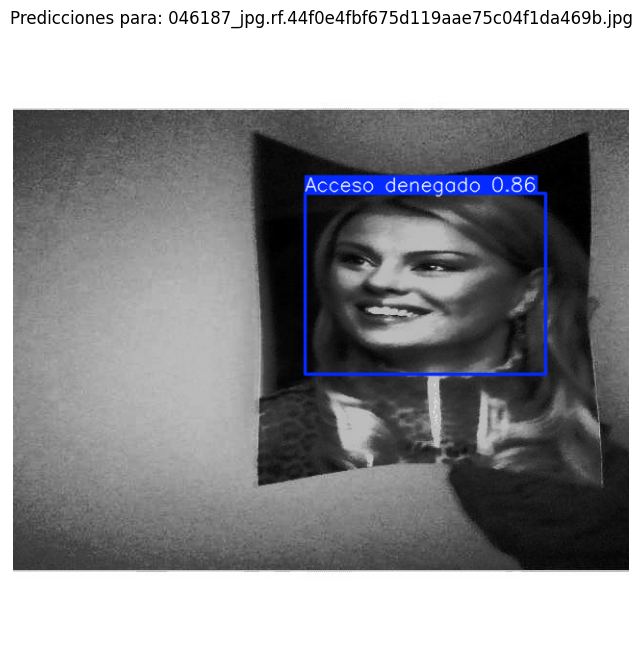

Clase: Acceso denegado | Confianza: 0.86

Ingresa el número de imagen a validar (0-91)
O ingresa 'q' para salir


Selección:  79



Procesando imagen: handling-angry-people_jpg.rf.98147a1d7d693904f3d78b1d2e7c7eff.jpg

image 1/1 /kaggle/working/Face-ID-2/test/images/handling-angry-people_jpg.rf.98147a1d7d693904f3d78b1d2e7c7eff.jpg: 640x640 1 Acceso denegado, 15.1ms
Speed: 1.7ms preprocess, 15.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


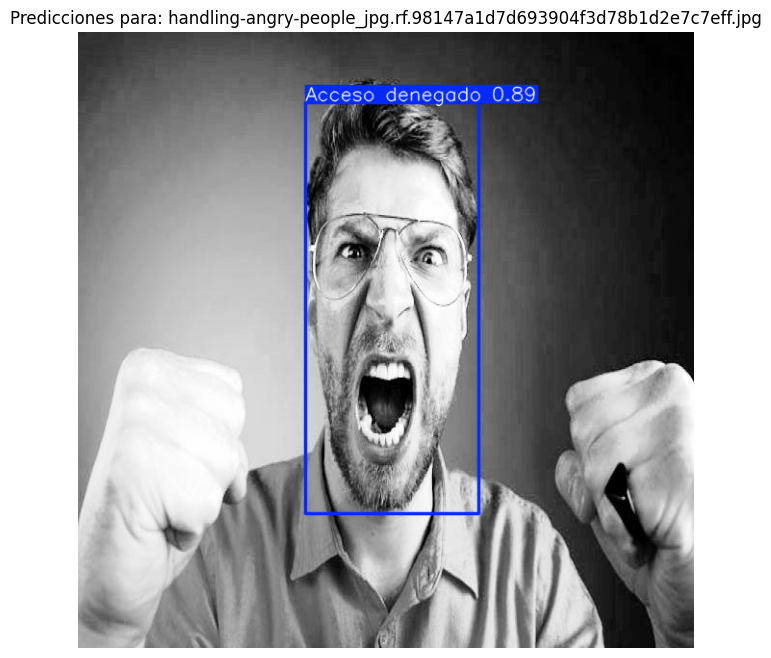

Clase: Acceso denegado | Confianza: 0.89

Ingresa el número de imagen a validar (0-91)
O ingresa 'q' para salir


Selección:  50



Procesando imagen: IMG_7758_JPG.rf.4d729d3c8c40634910a1527080d74acb.jpg

image 1/1 /kaggle/working/Face-ID-2/test/images/IMG_7758_JPG.rf.4d729d3c8c40634910a1527080d74acb.jpg: 640x640 1 Acceso permitido, 15.2ms
Speed: 1.8ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


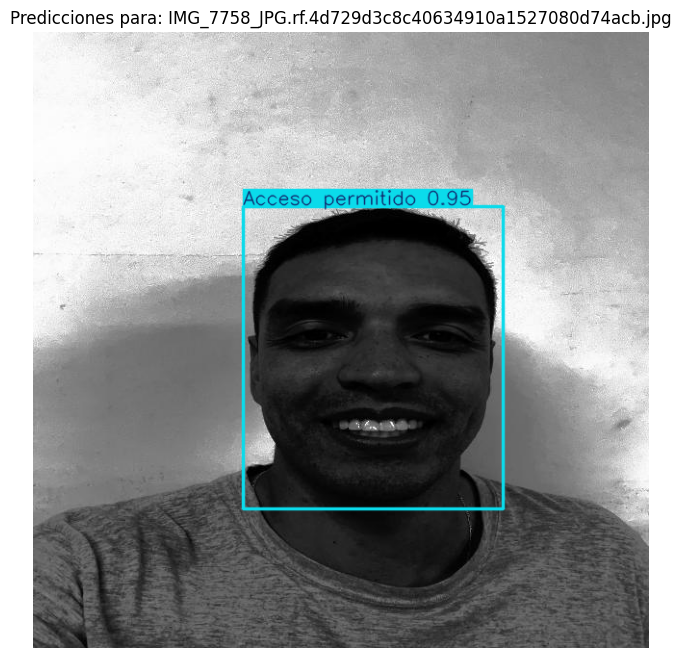

Clase: Acceso permitido | Confianza: 0.95

Ingresa el número de imagen a validar (0-91)
O ingresa 'q' para salir


Selección:  44



Procesando imagen: IMG_1835_JPG.rf.455ce98b56c3801aa0d0ce1f96737f00.jpg

image 1/1 /kaggle/working/Face-ID-2/test/images/IMG_1835_JPG.rf.455ce98b56c3801aa0d0ce1f96737f00.jpg: 640x640 1 Acceso permitido, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


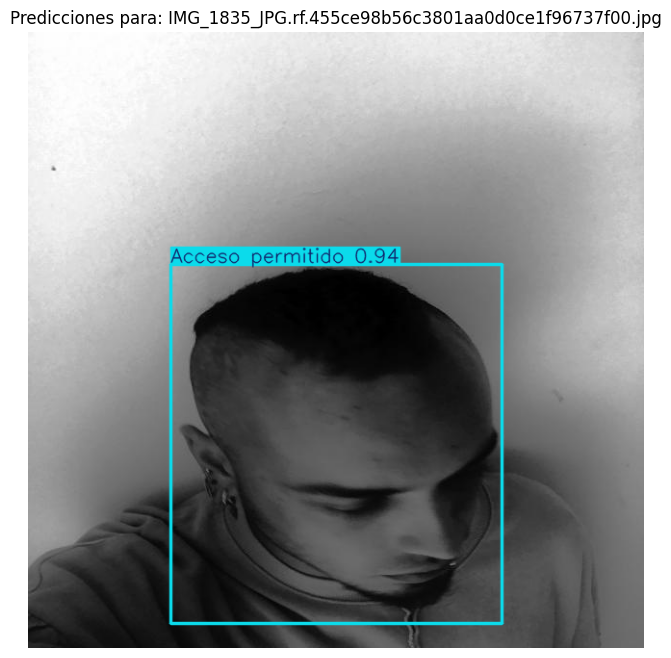

Clase: Acceso permitido | Confianza: 0.94

Ingresa el número de imagen a validar (0-91)
O ingresa 'q' para salir


Selección:  47



Procesando imagen: IMG_1864_JPG.rf.f20b51af74203f71e21c352d035bfac4.jpg

image 1/1 /kaggle/working/Face-ID-2/test/images/IMG_1864_JPG.rf.f20b51af74203f71e21c352d035bfac4.jpg: 640x640 1 Acceso permitido, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


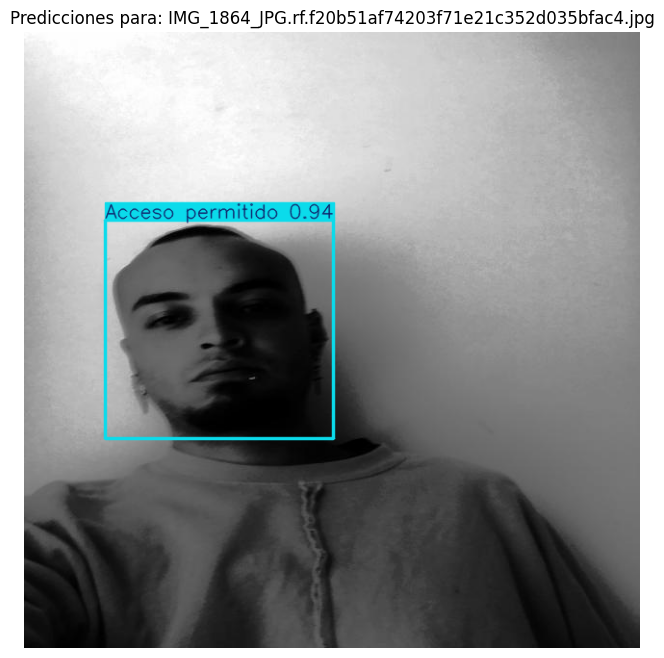

Clase: Acceso permitido | Confianza: 0.94

Ingresa el número de imagen a validar (0-91)
O ingresa 'q' para salir


Selección:  48



Procesando imagen: IMG_7745_JPG.rf.3bc955ee6928ffe7d3ad3b472bd85b14.jpg

image 1/1 /kaggle/working/Face-ID-2/test/images/IMG_7745_JPG.rf.3bc955ee6928ffe7d3ad3b472bd85b14.jpg: 640x640 1 Acceso permitido, 15.2ms
Speed: 1.7ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


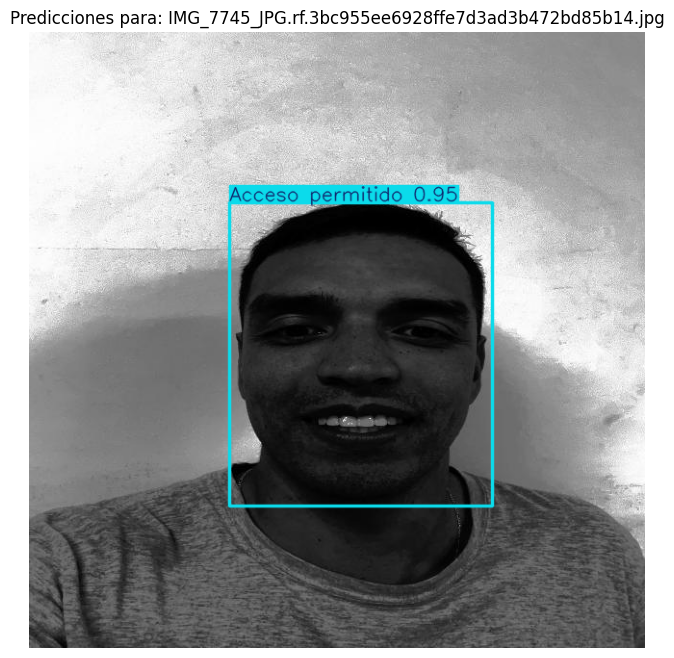

Clase: Acceso permitido | Confianza: 0.95

Ingresa el número de imagen a validar (0-91)
O ingresa 'q' para salir


Selección:  49



Procesando imagen: IMG_7751_JPG.rf.f2fb50daa519900455accf8460ab059e.jpg

image 1/1 /kaggle/working/Face-ID-2/test/images/IMG_7751_JPG.rf.f2fb50daa519900455accf8460ab059e.jpg: 640x640 1 Acceso permitido, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


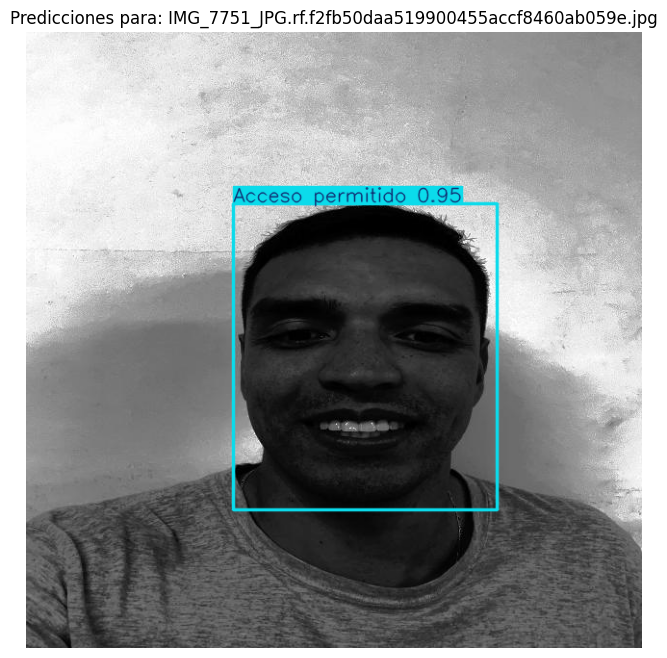

Clase: Acceso permitido | Confianza: 0.95

Ingresa el número de imagen a validar (0-91)
O ingresa 'q' para salir


Selección:  q


In [ ]:
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 1. Configuración inicial
model_path = '/kaggle/working/runs/detect/train/weights/best.pt'  # Revisa que esta ruta sea correcta
test_images_dir = '/kaggle/working/Face-ID-2/test/images'

# 2. Verificar existencia del modelo
if not os.path.exists(model_path):
    print(f"Error: No se encontró el modelo en {model_path}")
    print("Directorios disponibles en runs/detect:")
    print(os.listdir('/kaggle/working/runs/detect'))
    # Si el modelo no existe, deberás entrenarlo primero
    # model = YOLO('yolov10s.pt')
    # model.train(data='/kaggle/working/Face-ID-1/data_config.yaml', epochs=90, imgsz=640)
else:
    model = YOLO(model_path)

# 3. Obtener lista de imágenes disponibles
image_files = sorted([f for f in os.listdir(test_images_dir)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
image_paths = [os.path.join(test_images_dir, f) for f in image_files]

if not image_paths:
    print(f"No se encontraron imágenes en {test_images_dir}")
else:
    print("\nImágenes disponibles para validación:")
    for i, img_path in enumerate(image_paths):
        print(f"{i}: {os.path.basename(img_path)}")

    # 4. Función para validar imagen específica
    def validar_imagen(num_imagen):
        try:
            num_imagen = int(num_imagen)
            if num_imagen < 0 or num_imagen >= len(image_paths):
                print(f"Error: Ingresa un número entre 0 y {len(image_paths)-1}")
                return

            img_path = image_paths[num_imagen]
            print(f"\nProcesando imagen: {os.path.basename(img_path)}")

            # Realizar predicción
            results = model(img_path, imgsz=640, conf=0.3)

            # Mostrar resultados
            plt.figure(figsize=(10, 8))
            for r in results:
                plt.imshow(r.plot()[..., ::-1])  # Convertir BGR a RGB
                plt.axis('off')
                plt.title(f"Predicciones para: {os.path.basename(img_path)}")
                plt.show()

                # Mostrar información de las detecciones
                for box in r.boxes:
                    print(f"Clase: {model.names[int(box.cls)]} | Confianza: {box.conf.item():.2f}")

        except ValueError:
            print("Error: Ingresa un número válido")
        except Exception as e:
            print(f"Error al procesar la imagen: {str(e)}")

    # 5. Interfaz manual
    while True:
        print("\n" + "="*50)
        print(f"Ingresa el número de imagen a validar (0-{len(image_paths)-1})")
        print("O ingresa 'q' para salir")
        user_input = input("Selección: ")

        if user_input.lower() == 'q':
            break

        validar_imagen(user_input)

## Sistema Interactivo de Validación del Modelo

Este bloque implementa una herramienta completa para probar el modelo de reconocimiento facial con imágenes de prueba:

**Funcionalidades clave:**
1. **Carga inteligente del modelo**:
   - Verifica automáticamente la existencia del modelo entrenado
   - Proporciona mensajes claros si necesita entrenarse primero
   - Muestra la estructura de directorios para diagnóstico

2. **Gestión de imágenes de prueba**:
   - Escanea el directorio de test buscando formatos comunes (PNG/JPG/JPEG)
   - Genera una lista numerada interactiva
   - Muestra rutas completas para verificación

3. **Motor de predicción**:
   - Procesa imágenes con el modelo YOLOv10
   - Aplica parámetros óptimos (confianza=0.3, tamaño=640px)
   - Soporta batch processing automático

4. **Visualización profesional**:
   - Muestra imágenes con bounding boxes y etiquetas
   - Formato RGB correcto para visualización
   - Títulos descriptivos y ejes limpios

5. **Interfaz interactiva**:
   - Menú intuitivo con numeración automática
   - Validación de entradas del usuario
   - Opción para salir ('q')
   - Manejo elegante de errores

**Output detallado:**
- Para cada detección muestra:
  - Clase identificada ("Acceso permitido/denegado")
  - Nivel de confianza formateado a 2 decimales
  - Visualización gráfica con matplotlib

**Uso típico:**
1. El sistema lista las imágenes disponibles
2. Usuario ingresa número de imagen
3. Se procesa y muestra resultados
4. Ciclo continúa hasta que usuario ingresa 'q'

**Robustez:**
- Validación de rangos numéricos
- Manejo de excepciones completo
- Mensajes de error descriptivos


image 1/1 /kaggle/working/Face-ID-2/valid/images/WhatsApp-Image-2025-06-27-at-12_16_22-AM-20-_jpeg.rf.bd86ddb40ecd51f38239d457454892f9.jpg: 640x640 1 Acceso permitido, 15.1ms
Speed: 1.6ms preprocess, 15.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


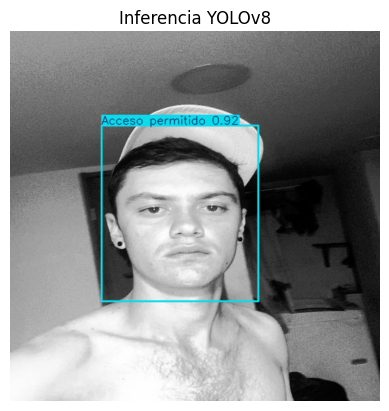

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Cargar el modelo
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

# Realizar inferencia
results = model.predict(
    source="/kaggle/working/Face-ID-2/valid/images/WhatsApp-Image-2025-06-27-at-12_16_22-AM-20-_jpeg.rf.bd86ddb40ecd51f38239d457454892f9.jpg",  # Ruta a la imagen
    conf=0.5,           # Umbral de confianza
    device=0,           # GPU
    show=False          # No abrir ventana (útil en notebooks)
)

# Mostrar imagen con anotaciones usando matplotlib
import numpy as np
from PIL import Image

# Convertir el resultado a imagen y mostrarlo
annotated_frame = results[0].plot()  # Imagen con cajas dibujadas (como np.array BGR)

# Convertir a RGB para matplotlib
annotated_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

plt.imshow(annotated_rgb)
plt.axis('off')
plt.title("Inferencia YOLOv8")
plt.show()


## Inferencia con Modelo YOLO para Reconocimiento Facial

Este bloque de código realiza la detección facial utilizando el modelo YOLO previamente entrenado:

**Componentes principales:**
1. **Carga del modelo**:
   - Utiliza los pesos guardados (`best.pt`) del entrenamiento
   - Soporta GPU para aceleración (device=0)

2. **Parámetros de predicción**:
   - `source`: Ruta a la imagen de prueba
   - `conf=0.5`: Filtra detecciones con menos del 50% de confianza
   - `show=False`: Desactiva visualización automática (ideal para notebooks)

3. **Procesamiento de resultados**:
   - `results[0].plot()`: Genera imagen con bounding boxes y etiquetas
   - Conversión BGR→RGB para visualización correcta con matplotlib

4. **Visualización mejorada**:
   - Gráfico con matplotlib para mejor integración en notebooks
   - Elimina ejes para enfoque en la imagen
   - Título descriptivo de la visualización

**Flujo de trabajo:**
1. Carga el modelo entrenado
2. Procesa la imagen especificada
3. Filtra detecciones por confianza
4. Convierte formato de color (OpenCV→Matplotlib)
5. Muestra resultados con estilo profesional

**Recomendaciones de uso:**
- Para probar con otras imágenes, cambiar la ruta en `source`
- Ajustar `conf` para mayor/menor sensibilidad
- Usar `device='cpu'` si no hay GPU disponible

In [ ]:
# Exportar el modelo a formato TorchScript
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")
model.export(
    format='torchscript',  # Formato de exportación
    imgsz=640,            # Tamaño de las imágenes
    data=yaml_path,        # Ruta al archivo YAML
    half=False
)
print("Modelo exportado a TorchScript.")

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv10s summary (fused): 106 layers, 7,218,774 parameters, 0 gradients, 21.4 GFLOPs

PyTorch: starting from '/kaggle/working/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (46.8 MB)

TorchScript: starting export with torch 2.6.0+cu124...
TorchScript: export success ✅ 3.1s, saved as '/kaggle/working/runs/detect/train/weights/best.torchscript' (28.1 MB)

Export complete (3.9s)
Results saved to /kaggle/working/runs/detect/train/weights
Predict:         yolo predict task=detect model=/kaggle/working/runs/detect/train/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=/kaggle/working/runs/detect/train/weights/best.torchscript imgsz=640 data=/kaggle/working/Face-ID-2/data_config.yaml  

## Exportación del Modelo a TorchScript

Este bloque de código convierte el modelo YOLO entrenado al formato TorchScript:

**Propósito clave:**
- Convertir el modelo a un formato portable y optimizado para producción

**Parámetros de exportación:**
1. `format='torchscript'`:
   - Exporta a formato TorchScript de PyTorch
   - Ideal para despliegue en servidores y dispositivos móviles

2. `imgsz=640`:
   - Mantiene el tamaño de entrada original (640x640 píxeles)
   - Consistente con el entrenamiento

3. `data=yaml_path`:
   - Incluye la configuración del dataset
   - Preserva los nombres de las clases y estructura

4. `half=False`:
   - Desactiva precisión FP16 (mejor compatibilidad)
   - Mantiene precisión FP32 completa

**Ventajas del formato TorchScript:**
- Independiente del código Python original
- Más eficiente para inferencia
- Compatible con diversos entornos de ejecución
- Soporta optimizaciones adicionales

**Resultado esperado:**
- Archivo `.torchscript` generado en el mismo directorio
- Mensaje de confirmación en consola
- Modelo listo para implementación en producción

**Nota importante:**  
La exportación preserva toda la funcionalidad del modelo pero requiere que el entorno de despliegue tenga las dependencias necesarias de PyTorch.

In [ ]:
# Función para cargar el modelo TorchScript
def load_torchscript_model(model_path, device='cpu'):
    """Carga un modelo en formato TorchScript.

    Args:
        model_path (str): Ruta al archivo del modelo.
        device (str): Dispositivo para cargar el modelo ('cpu' o 'cuda').
    Returns:
        model: Modelo cargado en modo evaluación.
    """
    model = torch.jit.load(model_path, map_location=device)
    model.eval()
    print(f"Modelo cargado desde {model_path} en {device}")
    return model

# Función para preprocesar imágenes
def preprocess_image(image_path, input_size=(640, 640)):
    """Preprocesa una imagen para inferencia con YOLO.

    Args:
        image_path (str): Ruta a la imagen.
        input_size (tuple): Tamaño al que redimensionar la imagen.
    Returns:
        tuple: Tensor de la imagen preprocesada y la imagen original.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, input_size)
    img_tensor = torch.from_numpy(img_resized).float().permute(2, 0, 1).unsqueeze(0) / 255.0
    return img_tensor, img

# Función para ejecutar inferencia
def run_inference(model, input_tensor, device='cpu'):
    """Ejecuta inferencia con el modelo TorchScript.

    Args:
        model: Modelo cargado.
        input_tensor: Tensor de entrada preprocesado.
        device (str): Dispositivo para la inferencia.
    Returns:
        outputs: Resultados de la inferencia.
    """
    input_tensor = input_tensor.to(device)
    with torch.no_grad():
        if device != 'cpu':
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)
            start_time.record()
            outputs = model(input_tensor)
            end_time.record()
            torch.cuda.synchronize()
            inference_time = start_time.elapsed_time(end_time)
        else:
            import time
            start = time.time()
            outputs = model(input_tensor)
            print(outputs.shape)
            inference_time = (time.time() - start) * 1000
    print(f"Tiempo de inferencia: {inference_time:.2f} ms")
    return outputs

# Función para visualizar detecciones
def visualize_detections(image_path, detections_tensor, confidence_threshold=0.5, output_path=None):
    """Visualiza las detecciones del modelo YOLO en una imagen.

    Args:
        image_path (str): Ruta a la imagen original.
        detections_tensor: Tensor con las detecciones.
        confidence_threshold (float): Umbral de confianza para filtrar detecciones.
        output_path (str, optional): Ruta para guardar la imagen con detecciones.
    """
    img = cv2.imread(image_path)
    print(detections_tensor[:,7,:])
    detections = detections_tensor[0] if len(detections_tensor.shape) == 3 else detections_tensor
    valid_detections = detections[detections[:, 4] >= confidence_threshold]

    # Generar colores aleatorios para las clases
    np.random.seed(42)
    colors = [(np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)) for _ in range(100)]

    # Dibujar detecciones en la imagen
    for detection in valid_detections:
        x1, y1, x2, y2, conf, cls_id = detection
        x1, y1, x2, y2, cls_id = int(x1), int(y1), int(x2), int(y2), int(cls_id)
        color = colors[cls_id % len(colors)]
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        label = f"Clase {cls_id}: {conf:.2f}"
        cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Guardar la imagen si se proporciona una ruta
    if output_path:
        cv2.imwrite(output_path, img)
    print(f"Detecciones mostradas: {len(valid_detections)}")

## Sistema de Inferencia con TorchScript

Este bloque implementa un pipeline completo para cargar y ejecutar modelos YOLO exportados a TorchScript:

### 1. Carga del Modelo (`load_torchscript_model`)
**Propósito**:  
Carga eficientemente el modelo exportado para inferencia

**Características clave**:
- Soporta CPU y GPU (CUDA)
- Pone el modelo en modo evaluación (`eval()`)
- Verificación automática del dispositivo disponible
- Mensaje informativo de carga exitosa

### 2. Preprocesamiento de Imágenes (`preprocess_image`)
**Flujo de transformación**:
1. Lectura de imagen con OpenCV
2. Conversión BGR→RGB
3. Redimensionamiento al tamaño de entrada del modelo
4. Normalización (0-1) y conversión a tensor PyTorch
5. Reordenamiento de dimensiones (HWC→CHW)

**Salida**:
- Tensor listo para inferencia
- Imagen original (para visualización)

### 3. Ejecución de Inferencia (`run_inference`)
**Optimizaciones**:
- Medición precisa del tiempo de inferencia
- Soporte para GPU con CUDA Events
- Modo sin gradientes para máxima eficiencia
- Sincronización CUDA para mediciones precisas

**Métricas**:
- Tiempo de ejecución en milisegundos
- Forma del tensor de salida (debug)

### 4. Visualización de Resultados (`visualize_detections`)
**Funcionalidades**:
- Filtrado por umbral de confianza
- Cajas delimitadoras con colores por clase
- Etiquetas informativas (clase + confianza)
- Opción para guardar resultados
- Conteo de detecciones válidas

**Personalización**:
- Umbral de confianza ajustable
- Paleta de colores consistente (semilla fija)
- Estilo de texto y bounding boxes configurable

### Flujo de Trabajo Típico
1. Cargar modelo con `load_torchscript_model`
2. Preprocesar imagen con `preprocess_image`
3. Ejecutar inferencia con `run_inference`
4. Visualizar resultados con `visualize_detections`

**Nota**: El sistema está diseñado para máxima portabilidad entre entornos de desarrollo y producción.

In [ ]:
# Ejemplo de uso
model = load_torchscript_model('/kaggle/working/runs/detect/train/weights/best.torchscript')

Modelo cargado desde /kaggle/working/runs/detect/train/weights/best.torchscript en cpu


**Función:** `load_torchscript_model()`  
- Es una función personalizada que carga modelos en formato TorchScript (la versión optimizada de PyTorch para producción)

**Parámetro:** `'/kaggle/working/runs/detect/train/weights/best.torchscript'`  
- Ruta del archivo del modelo guardado  
- Indica que está en un entorno de Kaggle  
- El modelo proviene de un entrenamiento de detección (probablemente YOLO o similar)  
- 'best.torchscript' suele ser el nombre por defecto del mejor modelo guardado

**Variable:** `model`  
- Almacena el modelo cargado para hacer predicciones/inferencias

**Uso típico:**  
1. Inferencia en producción  
2. Comparación de modelos  
3. Extracción de características  
4. Fine-tuning (ajuste fino)

**TorchScript vs PyTorch normal:**  
- Más eficiente para producción  
- Independiente del código Python original  
- Optimizado para velocidad

In [ ]:
input_tensor, original_img = preprocess_image('/kaggle/working/Face-ID-2/valid/images/WhatsApp-Image-2025-06-27-at-12_16_22-AM-20-_jpeg.rf.bd86ddb40ecd51f38239d457454892f9.jpg')

outputs = run_inference(model, input_tensor)
visualize_detections(
    "/kaggle/working/Face-ID-2/valid/images/WhatsApp-Image-2025-06-27-at-12_16_22-AM-20-_jpeg.rf.bd86ddb40ecd51f38239d457454892f9.jpg",
    outputs,
    confidence_threshold=0.5,
    output_path="result.jpg"
)

torch.Size([1, 300, 6])
Tiempo de inferencia: 358.56 ms
tensor([[2.8460e+02, 5.8428e+02, 6.1642e+02, 6.4017e+02, 2.1401e-03, 1.0000e+00]])
Detecciones mostradas: 1


## Procesamiento de la Imagen
**`preprocess_image()`**  
- **Función:** Prepara una imagen para el modelo (normalización, redimensionado, conversión a tensor)  
- **Salidas:**  
  - `input_tensor`: Imagen procesada en formato tensor (lista/array numérico)  
  - `original_img`: Imagen original sin modificar (para visualización)  
- **Ruta:** La imagen proviene de un dataset de prueba en Kaggle para reconocimiento facial  

## Ejecución del Modelo  
**`run_inference(model, input_tensor)`**  
- **Qué hace:** Ejecuta predicciones con el modelo cargado sobre el tensor preprocesado  
- **Salida (`outputs`):**  
  - Contiene detecciones (coordenadas de bounding boxes, clases, scores de confianza)  
  - Formato depende del modelo (Ej: YOLO retorna (x1, y1, x2, y2, confianza, clase))  

## Visualización de Resultados  
**`visualize_detections()`**  
- **Parámetros clave:**  
  - `confidence_threshold=0.5`: Filtra detecciones con <50% de confianza  
  - `output_path="result.jpg"`: Guarda la imagen con bounding boxes dibujados  
- **Proceso interno:**  
  1. Dibuja bounding boxes sobre `original_img`  
  2. Añade etiquetas (clase + confianza)  
  3. Guarda la imagen anotada  
